In [5]:
!pip install ktrain -q
!pip install pandarallel -q

In [6]:
import ktrain

import os
import shutil
import numpy as np
import pandas as pd
import json

In [7]:
from pandarallel import pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False, progress_bar=True)

Available CPUs: 2
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [8]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


### Importing the data

In [10]:
ROOT_PATH = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project"


In [11]:
TRAIN_JSONL_PATH = os.path.join(ROOT_PATH, "data_raw/train.jsonl")
EVAL_JSONL_PATH =  os.path.join(ROOT_PATH, "data_raw/dev.jsonl")
TEST_JSONL_PATH =  os.path.join(ROOT_PATH, "data_raw/test.jsonl")

def read_jsonl(path):
    # Open the JSONL file
    with open(path, 'r') as file:
        data_list = []
        
        # Read each line in the file
        for line in file:
            # Parse the JSON data from each line
            data = json.loads(line)
            
            # Append the JSON data to the list
            data_list.append(data)

    # Create a Pandas DataFrame from the list of JSON objects
    df = pd.DataFrame(data_list)
    return df

train = read_jsonl(TRAIN_JSONL_PATH)
eval_df = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

In [12]:
train["dataset"] = "train"
eval_df["dataset"] = "eval"
test["dataset"] = "test"

main_df = pd.concat([train, eval_df], ignore_index=True)
main_df.head()

,id,img,label,text,dataset
0,42953,img/42953.png,0,its their character not their color that matters,train
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0,putting bows on your pet,train
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train


In [13]:
import ktrain
from ktrain import text

In [14]:
# Split the data
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train,
                                                                   text_column='text',
                                                                   label_columns=['label'],
                                                                   val_pct=0.2,
                                                                   maxlen=350,
                                                                   max_features=35000,
                                                                   preprocess_mode='bert')

['not_label', 'label']
      not_label  label
407         1.0    0.0
2930        1.0    0.0
2699        1.0    0.0
1523        1.0    0.0
199         1.0    0.0
['not_label', 'label']
      not_label  label
7611        1.0    0.0
4174        1.0    0.0
5196        0.0    1.0
3297        1.0    0.0
5628        1.0    0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [15]:
# Create the model
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)


Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [16]:
# Train the model
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

learner.fit_onecycle(lr=2e-5, epochs=3, verbose=1)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1134/1134 [==============================] - 693s 589ms/step - loss: 0.6022 - accuracy: 0.6875 - val_loss: 0.5429 - val_accuracy: 0.7429
Epoch 2/3
1134/1134 [==============================] - 634s 559ms/step - loss: 0.5378 - accuracy: 0.7396 - val_loss: 0.5422 - val_accuracy: 0.7300
Epoch 3/3
1134/1134 [==============================] - 667s 589ms/step - loss: 0.4308 - accuracy: 0.7947 - val_loss: 0.5973 - val_accuracy: 0.6982


In [ ]:
train_loss = [0.6022, 0.5378, 0.4308]
eval_loss = [0.5429, 0.5422, 0.5973]

In [17]:
# Save the model
predictor = ktrain.get_predictor(learner.model, preproc)

In [18]:
y_true = list(eval_df["label"])
y_pred = predictor.predict(list(eval_df["text"]))


In [19]:
y_pred_train = predictor.predict(list(train["text"]))
y_true_train = list(train["label"])

In [22]:
y_pred = [1 if _p=="label" else 0 for _p in y_pred]
y_pred_train =  [1 if _p=="label" else 0 for _p in y_pred_train]

TRAIN SET: Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      5450
           1       0.77      0.70      0.74      3050

    accuracy                           0.82      8500
   macro avg       0.81      0.79      0.80      8500
weighted avg       0.82      0.82      0.82      8500



Text(0.5, 1.0, 'Confusion Matrix')

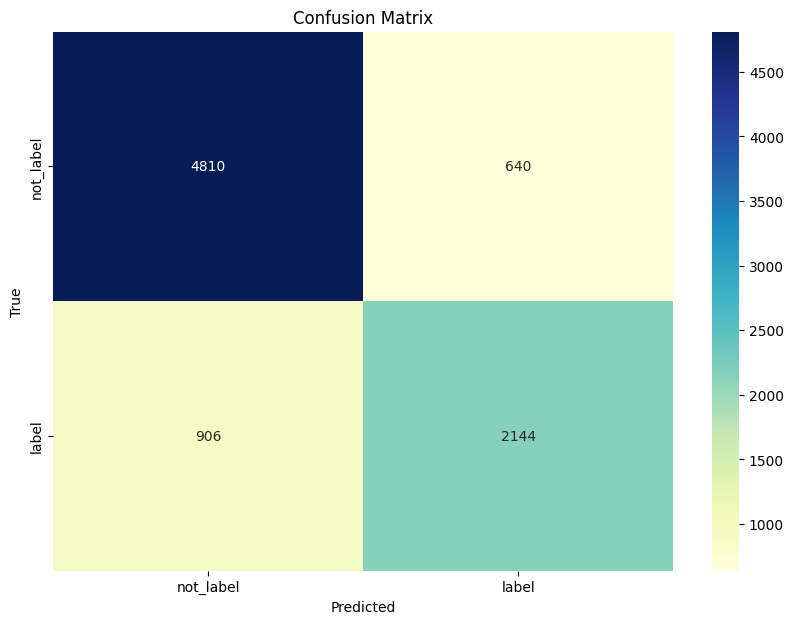

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("TRAIN SET: Classification Report:")
print(classification_report(y_true_train, y_pred_train))

# Confusion Matrix
cm = confusion_matrix(y_true_train, y_pred_train)

# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=preproc.get_classes(),
            yticklabels=preproc.get_classes())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

TEST SET: Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.89      0.67       250
           1       0.67      0.22      0.34       250

    accuracy                           0.56       500
   macro avg       0.60      0.56      0.50       500
weighted avg       0.60      0.56      0.50       500



Text(0.5, 1.0, 'Confusion Matrix')

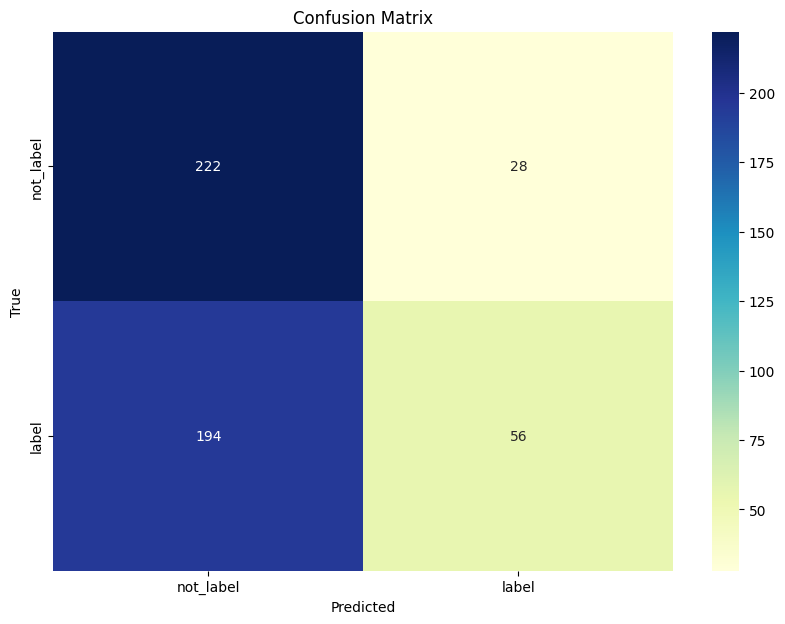

In [30]:
# Classification report
print("TEST SET: Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=preproc.get_classes(),
            yticklabels=preproc.get_classes())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')